DATA COLLECTION

In [ ]:
import requests
import pandas as pd
import datetime

# Your API key
API_KEY = "1164c94b43e182b37a6138e247cacc2e"

# Rawalpindi coordinates
LAT = 33.6844
LON = 73.0479

# Loop through each day in past year
end_date = datetime.datetime.utcnow()
start_date = end_date - datetime.timedelta(days=365)

data = []
for day in pd.date_range(start=start_date, end=end_date, freq='D'):
    unix_timestamp = int(day.timestamp())
    url = (f"http://api.openweathermap.org/data/2.5/air_pollution/history"
           f"?lat={LAT}&lon={LON}&start={unix_timestamp}&end={unix_timestamp+86400}"
           f"&appid={API_KEY}")
    response = requests.get(url)
    if response.ok:
        day_data = response.json().get('list', [])
        data.extend(day_data)

# Convert to DataFrame
df = pd.json_normalize(data)
df.to_csv('rawalpindi_aqi_history.csv', index=False)


In [ ]:
df.head()

,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3
0,1722621600,3,1508.71,0.12,52.78,20.03,4.89,39.33,46.05,12.29
1,1722625200,3,1375.20,0.03,46.61,25.03,4.53,40.95,47.12,10.77
2,1722628800,3,1148.22,0.00,32.90,38.27,4.11,39.73,44.75,8.49
3,1722632400,3,907.90,0.00,20.73,50.78,3.70,34.21,37.87,6.46
4,1722636000,3,747.68,0.00,13.88,55.07,3.19,27.16,30.03,5.32


Data Processing & Feature Engineering

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8520 entries, 0 to 8519
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dt                8520 non-null   int64  
 1   main.aqi          8520 non-null   int64  
 2   components.co     8520 non-null   float64
 3   components.no     8520 non-null   float64
 4   components.no2    8520 non-null   float64
 5   components.o3     8520 non-null   float64
 6   components.so2    8520 non-null   float64
 7   components.pm2_5  8520 non-null   float64
 8   components.pm10   8520 non-null   float64
 9   components.nh3    8520 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 665.8 KB
None


In [ ]:
df['datetime'] = pd.to_datetime(df['dt'], unit='s')
df = df.sort_values('datetime')


In [ ]:
print(df.isnull().sum())


dt                  0
main.aqi            0
components.co       0
components.no       0
components.no2      0
components.o3       0
components.so2      0
components.pm2_5    0
components.pm10     0
components.nh3      0
datetime            0
dtype: int64


In [ ]:

# Convert UNIX timestamp to readable date
df['datetime'] = pd.to_datetime(df['dt'], unit='s')
df = df.sort_values('datetime')



In [ ]:
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['month'] = df['datetime'].dt.month

# AQI change rate
df['aqi_change'] = df['main.aqi'].diff()


In [ ]:
# AQI change rate
df['aqi_change'] = df['main.aqi'].diff()
# Rolling average of AQI (3 hours)
df['aqi_roll3'] = df['main.aqi'].rolling(window=3).mean()


In [ ]:
# Ratio of PM2.5 to PM10
df['pm_ratio'] = df['components.pm2_5'] / df['components.pm10']
# Rolling averages for PM2.5 and PM10
df['pm2_5_roll3'] = df['components.pm2_5'].rolling(window=3).mean()
df['pm10_roll3'] = df['components.pm10'].rolling(window=3).mean()


In [ ]:
# Lagged AQI (previous hour)
df['aqi_lag1'] = df['main.aqi'].shift(1)
# Lagged PM2.5
df['pm2_5_lag1'] = df['components.pm2_5'].shift(1)


In [ ]:
df.head()

,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,...,day,weekday,month,aqi_change,aqi_roll3,pm_ratio,pm2_5_roll3,pm10_roll3,aqi_lag1,pm2_5_lag1
0,1722621600,3,1508.71,0.12,52.78,20.03,4.89,39.33,46.05,12.29,...,2,4,8,NaN,NaN,0.854072,NaN,NaN,NaN,NaN
1,1722625200,3,1375.20,0.03,46.61,25.03,4.53,40.95,47.12,10.77,...,2,4,8,0.0,NaN,0.869058,NaN,NaN,3.0,39.33
2,1722628800,3,1148.22,0.00,32.90,38.27,4.11,39.73,44.75,8.49,...,2,4,8,0.0,3.0,0.887821,40.003333,45.973333,3.0,40.95
3,1722632400,3,907.90,0.00,20.73,50.78,3.70,34.21,37.87,6.46,...,2,4,8,0.0,3.0,0.903354,38.296667,43.246667,3.0,39.73
4,1722636000,3,747.68,0.00,13.88,55.07,3.19,27.16,30.03,5.32,...,2,4,8,0.0,3.0,0.904429,33.700000,37.550000,3.0,34.21


In [ ]:
df = df.dropna()
df.to_csv('processed_aqi_features.csv', index=False)


MODEL TRAINING

In [ ]:
import pandas as pd

df = pd.read_csv("processed_aqi_features.csv")  # Use your file path


In [ ]:
df.head()

,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,...,day,weekday,month,aqi_change,aqi_roll3,pm_ratio,pm2_5_roll3,pm10_roll3,aqi_lag1,pm2_5_lag1
0,1722628800,3,1148.22,0.0,32.90,38.27,4.11,39.73,44.75,8.49,...,2,4,8,0.0,3.000000,0.887821,40.003333,45.973333,3.0,40.95
1,1722632400,3,907.90,0.0,20.73,50.78,3.70,34.21,37.87,6.46,...,2,4,8,0.0,3.000000,0.903354,38.296667,43.246667,3.0,39.73
2,1722636000,3,747.68,0.0,13.88,55.07,3.19,27.16,30.03,5.32,...,2,4,8,0.0,3.000000,0.904429,33.700000,37.550000,3.0,34.21
3,1722639600,2,694.27,0.0,12.00,48.64,2.98,23.59,26.30,5.57,...,2,4,8,-1.0,2.666667,0.896958,28.320000,31.400000,3.0,27.16
4,1722643200,2,687.60,0.0,12.17,42.92,2.92,22.66,25.28,6.46,...,3,5,8,0.0,2.333333,0.896361,24.470000,27.203333,2.0,23.59


In [ ]:
df.columns

Index(['dt', 'main.aqi', 'components.co', 'components.no', 'components.no2',
       'components.o3', 'components.so2', 'components.pm2_5',
       'components.pm10', 'components.nh3', 'datetime', 'hour', 'day',
       'weekday', 'month', 'aqi_change', 'aqi_roll3', 'pm_ratio',
       'pm2_5_roll3', 'pm10_roll3', 'aqi_lag1', 'pm2_5_lag1'],
      dtype='object')

In [ ]:
feature_cols = [
    # Original pollutant features
    'components.co', 'components.no', 'components.no2', 'components.o3',
    'components.so2', 'components.pm2_5', 'components.pm10', 'components.nh3',

    # Time-based features
    'hour', 'day', 'weekday', 'month',

    # Engineered features
    'aqi_change', 'aqi_roll3', 'pm_ratio',
    'pm2_5_roll3', 'pm10_roll3', 'aqi_lag1', 'pm2_5_lag1'
]


In [ ]:

X = df[feature_cols]
y = df['main.aqi']

In [ ]:
import pandas as pd

df = pd.read_csv('processed_aqi_features.csv')
split_idx = int(0.8 * len(df))  # 80% train, 20% test

X = df[feature_cols]
y = df['main.aqi']

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.02570170287727538
RMSE: 0.11208874723976701
R²: 0.9777478751781677


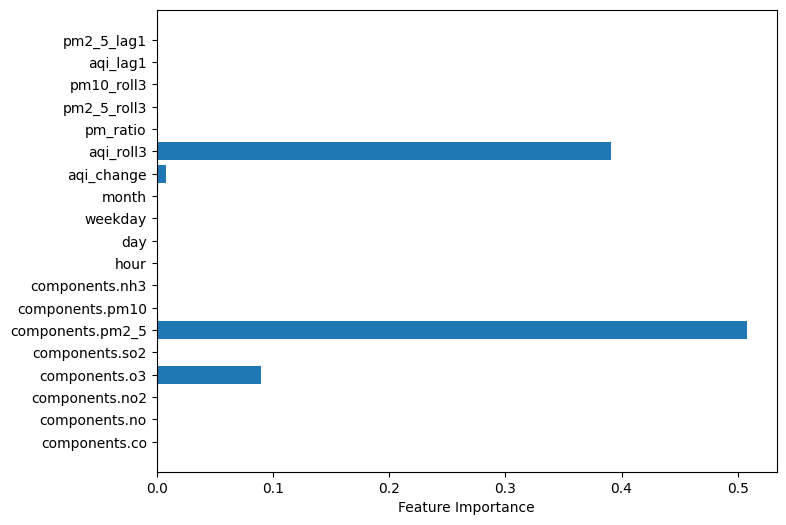

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(feature_cols, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.show()


In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)



In [ ]:
print("Ridge Regression:")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("RMSE:", np.sqrt(mse_ridge))
print("R²:", r2_score(y_test, y_pred_ridge))

Ridge Regression:
MAE: 0.0007608730403096098
RMSE: 0.0019431157837529016
R²: 0.9999933127922449


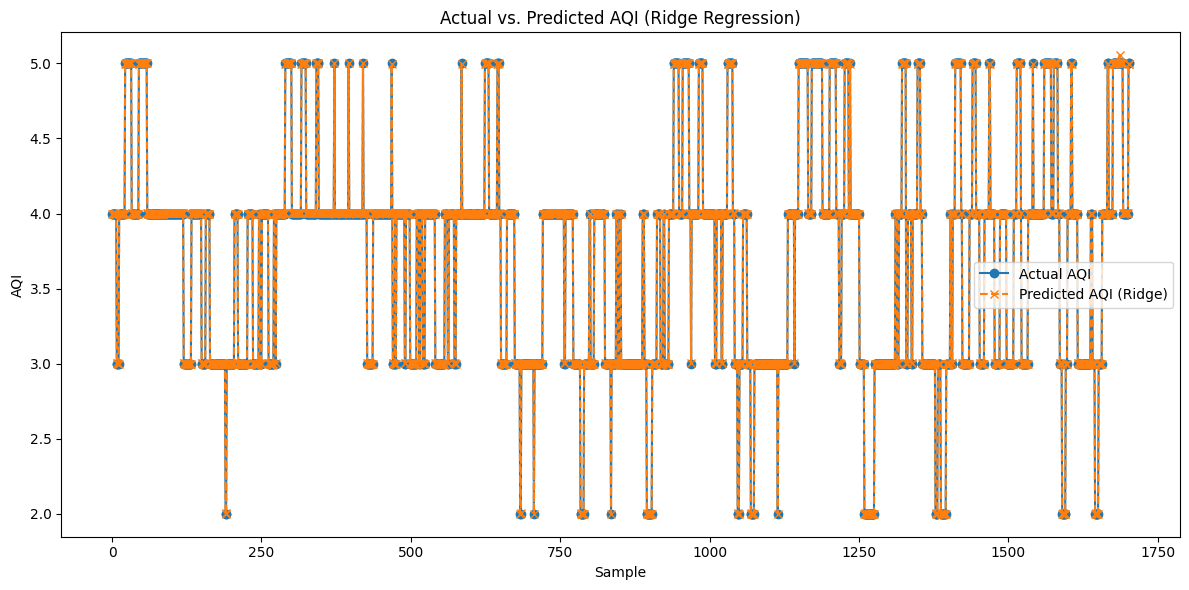

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual AQI', marker='o')
plt.plot(y_pred_ridge, label='Predicted AQI (Ridge)', linestyle='--', marker='x')
plt.title('Actual vs. Predicted AQI (Ridge Regression)')
plt.xlabel('Sample')
plt.ylabel('AQI')
plt.legend()
plt.tight_layout()
plt.show()


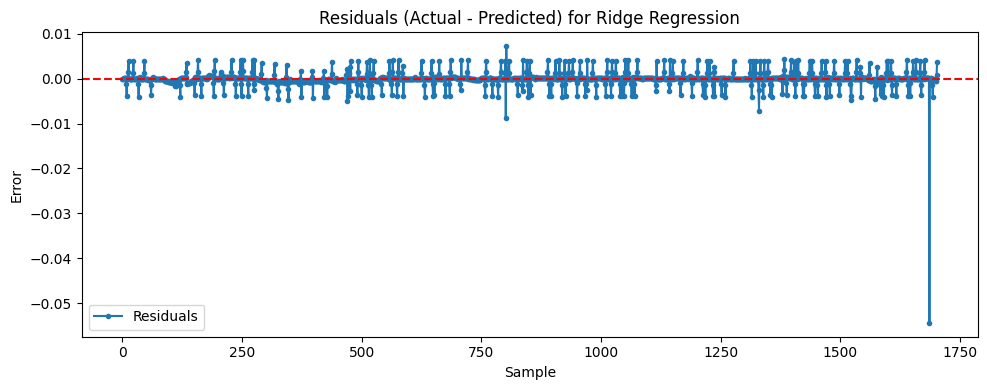

In [ ]:
residuals = y_test.values - y_pred_ridge

plt.figure(figsize=(10, 4))
plt.plot(residuals, label='Residuals', marker='.')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals (Actual - Predicted) for Ridge Regression')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!pip install xgboost



In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Regressor Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))

XGBoost Regressor Results:
MAE: 0.024782340973615646
RMSE: 0.10741759638501729
R²: 0.9795638918876648


In [ ]:
import joblib
joblib.dump(ridge, "ridge_model.pkl")


['ridge_model.pkl']

In [ ]:
# Get the last row (most recent observation with all features)
last_known = df.iloc[-1:].copy()
print(last_known[feature_cols].T)  # Show latest feature values


                        8514
components.co     516.710000
components.no       0.000000
components.no2      9.340000
components.o3      94.710000
components.so2      2.600000
components.pm2_5   78.640000
components.pm10   136.970000
components.nh3      4.190000
hour               17.000000
day                 3.000000
weekday             6.000000
month               8.000000
aqi_change          0.000000
aqi_roll3           4.666667
pm_ratio            0.574140
pm2_5_roll3        75.843333
pm10_roll3        135.860000
aqi_lag1            5.000000
pm2_5_lag1         76.310000


Step 2: Rolling Forecast for the Next 3 Days (72 Hours)

In [ ]:
import pandas as pd
import numpy as np

# last_known = last row as a DataFrame (already defined above)
# ridge = your trained Ridge Regression model
# feature_cols = your feature column list

future_steps = 72  # 3 days x 24 hours
forecast = []
last_row = last_known.copy()

for step in range(future_steps):
    # 1. Predict AQI for next hour
    pred_aqi = ridge.predict(last_row[feature_cols])[0]
    forecast.append(pred_aqi)

    # 2. Prepare the next input row (simulate "future" features)
    next_row = last_row.copy()

    # Update lag and rolling features
    next_row['aqi_lag1'] = last_row['main.aqi']
    next_row['pm2_5_lag1'] = last_row['components.pm2_5']

    # --- Fix for float warnings ---
    if step == 0:
        aqi_hist = [
            float(last_row['aqi_lag1'].iloc[0]),
            float(last_row['main.aqi'].iloc[0])
        ]
        pm2_5_hist = [
            float(last_row['pm2_5_lag1'].iloc[0]),
            float(last_row['components.pm2_5'].iloc[0])
        ]
        pm10_hist = [
            float(last_row['components.pm10'].iloc[0]),
            float(last_row['components.pm10'].iloc[0])
        ]
    else:
        aqi_hist.append(pred_aqi)
        pm2_5_hist.append(float(last_row['components.pm2_5'].iloc[0]))
        pm10_hist.append(float(last_row['components.pm10'].iloc[0]))

    # Rolling updates
    next_row['aqi_roll3'] = np.mean(aqi_hist[-3:])
    next_row['pm2_5_roll3'] = np.mean(pm2_5_hist[-3:])
    next_row['pm10_roll3'] = np.mean(pm10_hist[-3:])

    next_row['main.aqi'] = pred_aqi
    next_row['components.pm2_5'] = next_row['pm2_5_roll3']
    next_row['components.pm10'] = next_row['pm10_roll3']
    next_row['aqi_change'] = pred_aqi - float(last_row['main.aqi'].iloc[0])

    # --- Fix for ambiguous Series error ---
    next_hour = int(last_row['hour'].iloc[0]) + 1
    next_row['hour'] = next_hour % 24
    if next_row['hour'].iloc[0] == 0:  # New day
        next_row['day'] = int(last_row['day'].iloc[0]) + 1
        next_row['weekday'] = (int(last_row['weekday'].iloc[0]) + 1) % 7
    else:
        next_row['day'] = int(last_row['day'].iloc[0])
        next_row['weekday'] = int(last_row['weekday'].iloc[0])
    # (Month logic as needed)

    last_row = next_row.copy()


# Build forecast DataFrame
future_dates = pd.date_range(last_known['datetime'].values[0], periods=future_steps+1, freq='H')[1:]
forecast_df = pd.DataFrame({'datetime': future_dates, 'predicted_aqi': forecast})

print(forecast_df.head())


             datetime  predicted_aqi
0 2025-08-03 18:00:00       4.996377
1 2025-08-03 19:00:00       4.996851
2 2025-08-03 20:00:00       4.997292
3 2025-08-03 21:00:00       4.997687
4 2025-08-03 22:00:00       4.998095


/tmp/ipython-input-2051799327.py:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(last_known['datetime'].values[0], periods=future_steps+1, freq='H')[1:]


In [ ]:
import numpy as np
import pandas as pd

# last_known: DataFrame with your latest row (as shown above)
# ridge: trained Ridge Regression model
# feature_cols: your feature column list

future_steps = 72  # 3 days × 24 hours
forecast = []
last_row = last_known.copy()

# Initialize history for rolling features
aqi_hist = [
    float(last_row['aqi_lag1'].iloc[0]),
    float(last_row['main.aqi'].iloc[0])
]
pm2_5_hist = [
    float(last_row['pm2_5_lag1'].iloc[0]),
    float(last_row['components.pm2_5'].iloc[0])
]
pm10_hist = [
    float(last_row['components.pm10'].iloc[0]),
    float(last_row['components.pm10'].iloc[0])
]

for step in range(future_steps):
    # 1. Predict AQI for next hour
    pred_aqi = ridge.predict(last_row[feature_cols])[0]
    forecast.append(pred_aqi)

    # 2. Prepare the next input row (simulate "future" features)
    next_row = last_row.copy()

    # Update lag features
    next_row['aqi_lag1'] = last_row['main.aqi']
    next_row['pm2_5_lag1'] = last_row['components.pm2_5']

    # Update rolling histories
    aqi_hist.append(pred_aqi)
    pm2_5_hist.append(float(last_row['components.pm2_5'].iloc[0]))
    pm10_hist.append(float(last_row['components.pm10'].iloc[0]))

    # Rolling averages (last 3 values)
    next_row['aqi_roll3'] = np.mean(aqi_hist[-3:])
    next_row['pm2_5_roll3'] = np.mean(pm2_5_hist[-3:])
    next_row['pm10_roll3'] = np.mean(pm10_hist[-3:])

    # Simulate future values
    next_row['main.aqi'] = pred_aqi
    next_row['components.pm2_5'] = next_row['pm2_5_roll3']
    next_row['components.pm10'] = next_row['pm10_roll3']
    next_row['aqi_change'] = pred_aqi - float(last_row['main.aqi'].iloc[0])

    # Update time features (handle rollover)
    next_hour = int(last_row['hour'].iloc[0]) + 1
    next_row['hour'] = next_hour % 24
    if next_row['hour'].iloc[0] == 0:  # New day
        next_row['day'] = int(last_row['day'].iloc[0]) + 1
        next_row['weekday'] = (int(last_row['weekday'].iloc[0]) + 1) % 7
    else:
        next_row['day'] = int(last_row['day'].iloc[0])
        next_row['weekday'] = int(last_row['weekday'].iloc[0])
    # You can add month logic if needed

    # Move to next prediction
    last_row = next_row.copy()

# Create forecast DataFrame
future_dates = pd.date_range(last_known['datetime'].values[0], periods=future_steps+1, freq='H')[1:]
forecast_df = pd.DataFrame({'datetime': future_dates, 'predicted_aqi': forecast})

print(forecast_df.head())


             datetime  predicted_aqi
0 2025-08-03 18:00:00       4.996377
1 2025-08-03 19:00:00       4.996811
2 2025-08-03 20:00:00       4.997190
3 2025-08-03 21:00:00       4.997573
4 2025-08-03 22:00:00       4.997958


/tmp/ipython-input-3568768993.py:69: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(last_known['datetime'].values[0], periods=future_steps+1, freq='H')[1:]


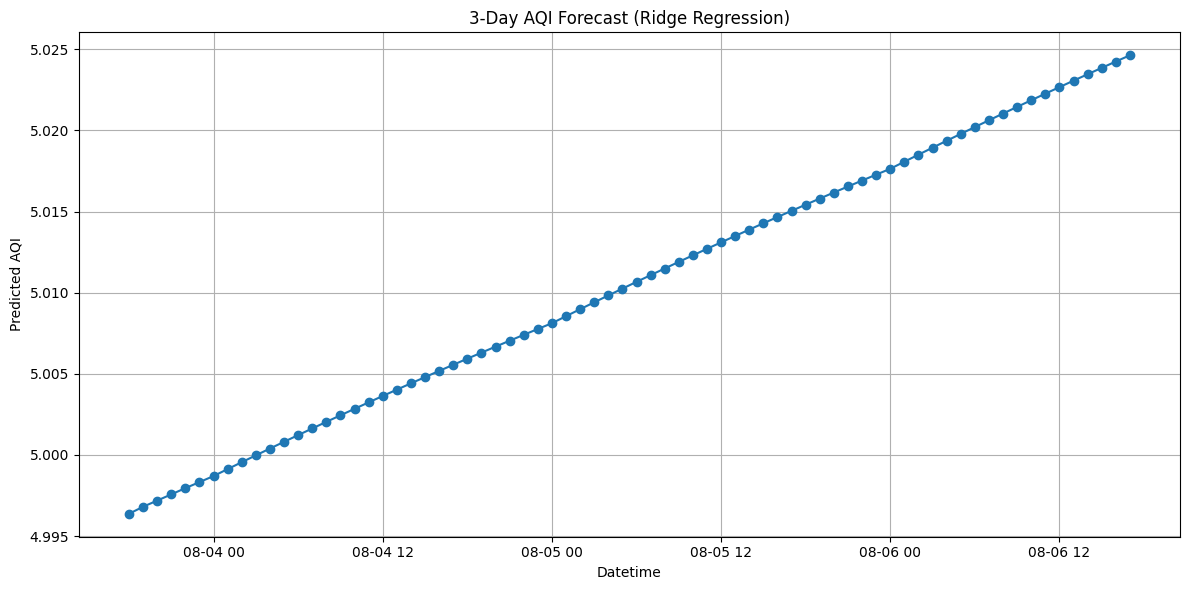

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(forecast_df['datetime'], forecast_df['predicted_aqi'], marker='o')
plt.title('3-Day AQI Forecast (Ridge Regression)')
plt.xlabel('Datetime')
plt.ylabel('Predicted AQI')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.2 MB/s eta 0:00:00


2025-08-02 17:19:29.719 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-02 17:19:29.924 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-02 17:19:29.927 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-02 17:19:29.929 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-02 17:19:29.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-02 17:19:29.936 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-02 17:19:29.940 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-02 17:19:30.723 Thread 'MainThread': mi

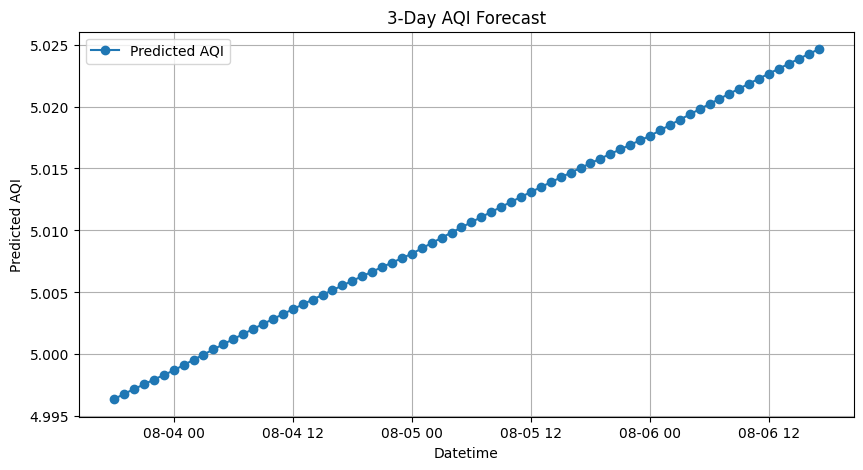

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

st.title("Rawalpindi AQI 3-Day Forecast Dashboard")
st.write("This dashboard generates and displays predicted AQI for the next 3 days using your trained Ridge Regression model.")

# Load the trained Ridge model
ridge = joblib.load('ridge_model.pkl')

# Load your processed full dataset (the same you used for training)
df = pd.read_csv('processed_aqi_features.csv')

# Get the most recent row as the starting point for forecasting
last_known = df.iloc[[-1]].copy()  # The double brackets keep it as a DataFrame

# Feature columns (same as used for training)
feature_cols = [
    'components.co', 'components.no', 'components.no2', 'components.o3',
    'components.so2', 'components.pm2_5', 'components.pm10', 'components.nh3',
    'hour', 'day', 'weekday', 'month', 'aqi_change', 'aqi_roll3', 'pm_ratio',
    'pm2_5_roll3', 'pm10_roll3', 'aqi_lag1', 'pm2_5_lag1'
]

# Rolling forecast code (copy-paste from above)
future_steps = 72  # 3 days × 24 hours
forecast = []
last_row = last_known.copy()

# Initialize history for rolling features
aqi_hist = [
    float(last_row['aqi_lag1'].iloc[0]),
    float(last_row['main.aqi'].iloc[0])
]
pm2_5_hist = [
    float(last_row['pm2_5_lag1'].iloc[0]),
    float(last_row['components.pm2_5'].iloc[0])
]
pm10_hist = [
    float(last_row['components.pm10'].iloc[0]),
    float(last_row['components.pm10'].iloc[0])
]

for step in range(future_steps):
    pred_aqi = ridge.predict(last_row[feature_cols])[0]
    forecast.append(pred_aqi)

    next_row = last_row.copy()
    next_row['aqi_lag1'] = last_row['main.aqi']
    next_row['pm2_5_lag1'] = last_row['components.pm2_5']
    aqi_hist.append(pred_aqi)
    pm2_5_hist.append(float(last_row['components.pm2_5'].iloc[0]))
    pm10_hist.append(float(last_row['components.pm10'].iloc[0]))
    next_row['aqi_roll3'] = np.mean(aqi_hist[-3:])
    next_row['pm2_5_roll3'] = np.mean(pm2_5_hist[-3:])
    next_row['pm10_roll3'] = np.mean(pm10_hist[-3:])
    next_row['main.aqi'] = pred_aqi
    next_row['components.pm2_5'] = next_row['pm2_5_roll3']
    next_row['components.pm10'] = next_row['pm10_roll3']
    next_row['aqi_change'] = pred_aqi - float(last_row['main.aqi'].iloc[0])
    next_hour = int(last_row['hour'].iloc[0]) + 1
    next_row['hour'] = next_hour % 24
    if next_row['hour'].iloc[0] == 0:
        next_row['day'] = int(last_row['day'].iloc[0]) + 1
        next_row['weekday'] = (int(last_row['weekday'].iloc[0]) + 1) % 7
    else:
        next_row['day'] = int(last_row['day'].iloc[0])
        next_row['weekday'] = int(last_row['weekday'].iloc[0])
    last_row = next_row.copy()

# Create forecast DataFrame
future_dates = pd.date_range(last_known['datetime'].values[0], periods=future_steps+1, freq='h')[1:]
forecast_df = pd.DataFrame({'datetime': future_dates, 'predicted_aqi': forecast})

# Visualization and display
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pd.to_datetime(forecast_df['datetime']), forecast_df['predicted_aqi'], marker='o', label='Predicted AQI')
ax.set_xlabel('Datetime')
ax.set_ylabel('Predicted AQI')
ax.set_title('3-Day AQI Forecast')
ax.grid(True)
ax.legend()
st.pyplot(fig)

st.subheader("Forecast Data")
st.dataframe(forecast_df)

hazardous = forecast_df['predicted_aqi'] > 4  # Set your own threshold
if hazardous.any():
    st.error("Warning: Hazardous AQI predicted in next 3 days!")
else:
    st.success("No hazardous AQI predicted in next 3 days.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')